In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from scipy.interpolate import splev, splrep
from settings import *
from matplotlib.lines import Line2D
from tools import *
fontsize = 20


Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Effective area

In [3]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
print(len(ra_mids), "RA bins")

140 log_10(energy) bins
100 declination bins
99 RA bins


# Detection efficiencies

In [4]:
with open(join(BASEPATH, "resources/detection_efficiencies.pckl"), "rb") as f:
    det_eff, padded_sd = pickle.load(f)

# Current discovery potential

In [14]:
## NGC1068 paper
# ngc: 
phi_ngc_32 = 6.75693e-11 # gamma=-3.2
phi_ngc_20 = 9.63442e-13 # gamma=-2.0
# txs:
phi_txs_32 =  4.39509e-11 # gamma=-3.2
phi_txs_20 = 7.51983e-13 # gamma=-2.0

# load the data
ps_disc = dict()
ind_disc = dict()
xsd = dict()
ic_10yr = dict()
spl_10yr = dict()


gamma = 2.0
ps_disc[gamma] = np.genfromtxt(
    join(LOCALPATH, "ngc_DP_gamma-2.txt"), delimiter=","
)
gamma = 3.2
ps_disc[gamma] = np.genfromtxt(
    join(LOCALPATH, "ngc_DP_gamma-3,2.txt"), delimiter=","
)
gammas = ps_disc.keys()

for gamma in ps_disc:
    ind_disc[gamma] = np.argsort(ps_disc[gamma][:, 0])
    xsd[gamma] = ps_disc[gamma][:, 0][ind_disc[gamma]]
    ic_10yr[gamma] = ps_disc[gamma][:, 1][ind_disc[gamma]] * 1E-12
    spl_10yr[gamma] = splrep(xsd[gamma], ic_10yr[gamma])

reference_ddecs = np.array([ngc1068.dec.deg, 30])
reference_sdecs = np.sin(np.deg2rad(reference_ddecs))

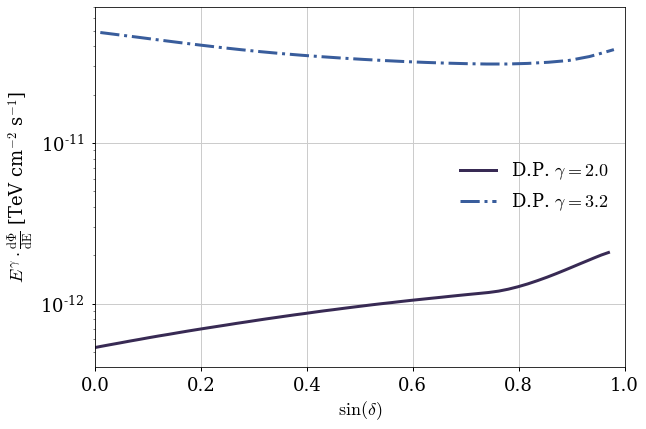

In [17]:
fig, ax = plt.subplots(figsize=(9, 6))
gamma = 2.0 
ax.plot(xsd[gamma], ic_10yr[gamma], ls='-', lw=3, label=fr'D.P. $\gamma={gamma}$')
gamma = 3.2
ax.plot(xsd[gamma], ic_10yr[gamma], ls='-.', lw=3, label=fr'D.P. $\gamma={gamma}$')

ax.legend(loc=0, ncol=1, frameon=False)
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$E^{\gamma} \cdot \frac{\rm d\Phi}{\rm dE}$ [TeV cm$^{-2}$ s$^{-1}$]')
ax.set_yscale('log')
ax.set_xlim(-0.01, 1)
fig.tight_layout()


# DP scaling estimation
Idea:
* Discovery potential improvement for same time -> translated from scaling in effective area

$R = \frac{\Phi_0}{\Phi_{\rm new}} = \left( \frac{t_0}{t_{\rm new}} \right)^{-0.8} = \left( \frac{t_{\rm new}}{t_0} \right)^{0.8} = \left( \frac{\int dE \cdot A_{\rm eff, new} \cdot d\Phi/dE}{\int dE A_{\rm eff, 0} \cdot d\Phi/dE} \right)^{0.8} \equiv \left( \frac{\epsilon_{\rm new}}{\epsilon_{\rm IC}} \right)^{0.8}$

$\Rightarrow \Phi_{\rm new} = \frac{\Phi_{IC}}{R} = \Phi_{IC} \cdot \left( \frac{\epsilon_{\rm IC}}{\epsilon_{\rm new}} \right)^{0.8}$ (with detection efficiency = $\epsilon$)

* Alternative: adding known discovery potentials via
$ \Phi_{add} = \Phi_0 \oplus \Phi_1  := \left( \Phi_0^{-1/0.8} + \Phi_1^{-1/0.8} \right)^{-0.8} $

In [20]:
from matplotlib.legend_handler import HandlerBase


class AnyObjectHandler(HandlerBase):
    def create_artists(
        self, legend, orig_handle, x0, y0, width, height, fontsize, trans
    ):
        l1 = plt.Line2D(
            [x0, y0 + width], [0.7 * height, 0.7 * height], color="tab:blue", lw=3
        )
        l2 = plt.Line2D(
            [x0, y0 + width], [0.3 * height, 0.3 * height], color="tab:orange", lw=3
        )
        return [l1, l2]


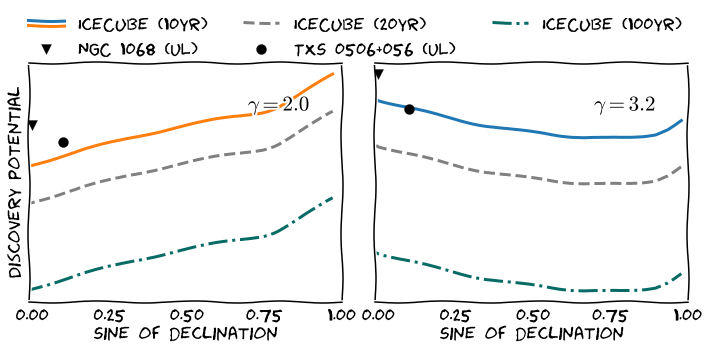

In [24]:
fontsize = 18
### simple sketchy plot as teaser
with plt.xkcd():
    f, axes = plt.subplots(ncols=2, figsize=(10, 5))
    gamma = 2.0
    ax = axes[0]

    ic_20yr = ic_10yr[gamma] * (
        0.5**0.8
    )  # double time from 10yr baseline to 20yr
    ic_50yr = ic_10yr[gamma] * (
        0.2**0.8
    )  # double time from 10yr baseline to 50yr
    ic_100yr = ic_10yr[gamma] * (
        0.1**0.8
    )  # double time from 10yr baseline to 100yr

    ax.plot(xsd[gamma], ic_10yr[gamma], color="tab:orange", ls="-", lw=3)
    ax.scatter(
        np.sin(ngc1068.icrs.dec),
        phi_ngc_20,
        marker="v",
        color="k",
        label="NGC 1068 (UL)",
        zorder=10,
        s=100,
    )
    ax.plot(xsd[gamma], ic_20yr, color="gray", ls="--", lw=3, label=r"IceCube (20yr)")
    ax.scatter(
        np.sin(txs0506.icrs.dec),
        phi_txs_20,
        marker="o",
        color="k",
        label="TXS 0506+056 (UL)",
        zorder=10,
        s=100,
    )
    ax.plot(
        xsd[gamma], ic_100yr, color=colors[2], ls="-.", lw=3, label=r"IceCube (100yr)"
    )

    ax.set_xlabel("Sine of declination", fontsize=fontsize)
    ax.set_yscale("log")
    ax.set_yticks([])
    ax.set_xlim(-0.01, 1)
    ax.text(
        0.7,
        0.8,
        r"$\gamma={0:.1f}$".format(gamma),
        fontsize=fontsize + 3,
        transform=ax.transAxes,
    )
    ax.set_ylabel(r"Discovery potential", fontsize=fontsize)
    ax.tick_params(axis="both", which="both", length=0)

    handles, labels = ax.get_legend_handles_labels()
    handles.insert(0, object)
    labels.insert(0, r"IceCube (10yr)")
    f.legend(
        handles,
        labels,
        handler_map={object: AnyObjectHandler()},
        loc="upper center",
        ncol=3,
        frameon=False,
        fontsize=fontsize,
    )

    gamma = 3.2
    ax = axes[1]
    ic_20yr = ic_10yr[gamma] * (
        0.5**0.8
    )  # double time from 10yr baseline to 20yr
    ic_50yr = ic_10yr[gamma] * (
        0.2**0.8
    )  # double time from 10yr baseline to 50yr
    ic_100yr = ic_10yr[gamma] * (
        0.1**0.8
    )  # double time from 10yr baseline to 100yr

    ax.plot(xsd[gamma], ic_10yr[gamma], color="tab:blue", ls="-", lw=3)
    ax.scatter(
        np.sin(ngc1068.icrs.dec),
        phi_ngc_32,
        marker="v",
        color="k",
        label="NGC 1068 (UL)",
        zorder=10,
        s=100,
    )
    ax.plot(xsd[gamma], ic_20yr, color="gray", ls="--", lw=3, label=r"IceCube (20yr)")
    ax.scatter(
        np.sin(txs0506.icrs.dec),
        phi_txs_32,
        marker="o",
        color="k",
        label="TXS 0506+056 (UL)",
        zorder=10,
        s=100,
    )
    ax.plot(
        xsd[gamma], ic_100yr, color=colors[2], ls="-.", lw=3, label=r"IceCube (100yr)"
    )
    ax.set_xlabel("Sine of declination", fontsize=fontsize)
    ax.set_yscale("log")
    ax.set_yticks([])
    ax.set_xlim(-0.01, 1)
    ax.text(
        0.7,
        0.8,
        r"$\gamma={0:.1f}$".format(gamma),
        fontsize=fontsize + 3,
        transform=ax.transAxes,
    )
    ax.tick_params(axis="both", which="both", length=0)
    f.tight_layout()
    plt.subplots_adjust(top=0.82)
    f.savefig(join(BASEPATH, f"plots/PLENUM_ps_disc_pot_comparison_sketch.pdf"), bbox_inches="tight")
fontsize = 20


# PS scaling

various detector combinations

In [26]:
gen2 = dict()
ic_20yr = dict()
ic_ntn = dict()
pone = dict()
plenum1 = dict()
plenum2 = dict()
ic_plenum1 = dict()
ic_plenum2 = dict()

In [27]:
for gamma in gammas:
    ic_20yr[gamma] = ic_10yr[gamma] * (
        0.5**0.8
    )  # double time from 10yr baseline to 20yr
    # plenum-1 10yr
    ic_ntn[gamma] = (
        ic_10yr[gamma]
        * (
            np.exp(det_eff[gamma]["IceCube"](xsd[gamma]))
            / (
                np.exp(det_eff[gamma]["IceCube"](xsd[gamma]))
                + np.exp(det_eff[gamma]["P-ONE"](xsd[gamma]))
            )
        )
        ** 0.8
    )
    # pone 10yr
    pone[gamma] = ic_10yr[gamma] * np.exp(
        (det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["P-ONE"](xsd[gamma]))
        * 0.8
    )
    # gen2 10yr
    gen2[gamma] = ic_10yr[gamma] * np.exp(
        (det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))
        * 0.8
    )
    # plenum-1 10yr
    plenum1[gamma] = ic_10yr[gamma] * np.exp(
        (det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum-1"](xsd[gamma]))
        * 0.8
    )
    # plenum-2 10yr
    plenum2[gamma] = ic_10yr[gamma] * np.exp(
        (det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum-2"](xsd[gamma]))
        * 0.8
    )
    # 10 yr icecube, then 10yr plenum-1 (with icecube)
    ic_plenum1[gamma] = (
        ic_10yr[gamma] ** (-1 / 0.8) + plenum1[gamma] ** (-1 / 0.8)
    ) ** -0.8
    # 10 yr icecube, then 10yr plenum-2 (with gen2)
    ic_plenum2[gamma] = (
        ic_10yr[gamma] ** (-1 / 0.8) + plenum2[gamma] ** (-1 / 0.8)
    ) ** -0.8


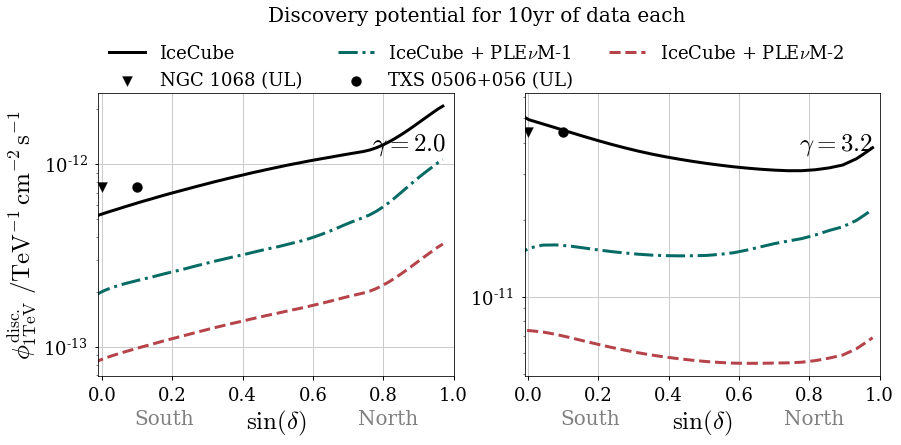

In [33]:
f, axes = plt.subplots(ncols=2, figsize=(14, 6))

for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    # conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
    const = 1  #  10**(-2*gamma) / 1.e3

    ax.plot(
        xsd[gamma],
        ic_10yr[gamma] * const,
        color="k",
        ls="-",
        lw=3,
        label=r"IceCube" if ii == 0 else "",
    )
    ax.scatter(
        np.sin(ngc1068.icrs.dec),
        phi_txs_20 if gamma == 2 else phi_txs_32,
        marker="v",
        color="k",
        label="NGC 1068 (UL)" if gamma == 2 else "",
        zorder=10,
        s=100,
    )
    ax.plot(
        xsd[gamma],
        ic_plenum1[gamma] * const,
        color=colors[2],
        ls="-.",
        lw=3,
        label=r"IceCube + PLE$\nu$M-1" if ii == 0 else "",
    )
    ax.scatter(
        np.sin(txs0506.icrs.dec),
        phi_txs_20 if gamma == 2 else phi_txs_32,
        marker="o",
        color="k",
        label="TXS 0506+056 (UL)" if gamma == 2 else "",
        zorder=10,
        s=100,
    )
    ax.plot(
        xsd[gamma],
        ic_plenum2[gamma] * const,
        color=colors[3],
        ls="--",
        lw=3,
        label=r"IceCube + PLE$\nu$M-2" if ii == 0 else "",
    )
    ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k", lw=1)
    ax.set_yscale("log")
    ax.set_xlim(-0.01, 1)
    ax.tick_params(axis="both", which="major")

    ylim = ax.get_ylim()
    ax.text(
        0.98,
        0.8,
        r"$\gamma={0:.1f}$".format(gamma),
        fontsize=fontsize + 5,
        transform=ax.transAxes,
        ha="right",
    )

    ax.set_xlabel(r"$\sin(\delta)$", fontsize=fontsize + 5)
    ax.text(
        0.1,
        -0.17,
        "South",
        fontsize=fontsize,
        fontdict=dict(color="gray"),
        transform=ax.transAxes,
    )
    ax.text(
        0.9,
        -0.17,
        "North",
        fontsize=fontsize,
        fontdict=dict(color="gray"),
        transform=ax.transAxes,
        ha="right",
    )
axes[0].set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$",
    fontsize=fontsize + 5,
)

f.legend(
    loc="upper center",
    ncol=3,
    frameon=False,
    fontsize=fontsize - 2,
    bbox_to_anchor=(0.5, 0.93),
)
f.subplots_adjust(top=0.78)
f.suptitle("Discovery potential for 10yr of data each", fontsize=fontsize)
f.savefig(
    join(BASEPATH, f"plots/plenum_ps_disc_pot_comparison_gamma23.pdf"),
    bbox_inches="tight",
)


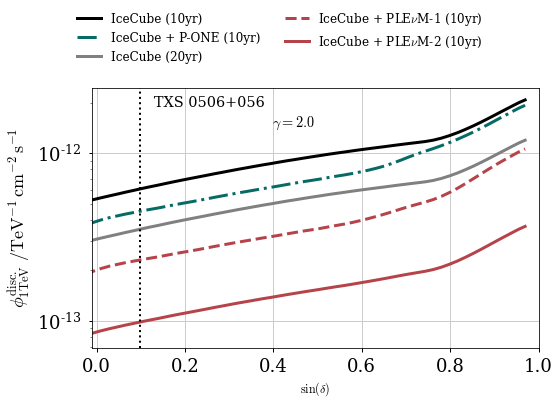

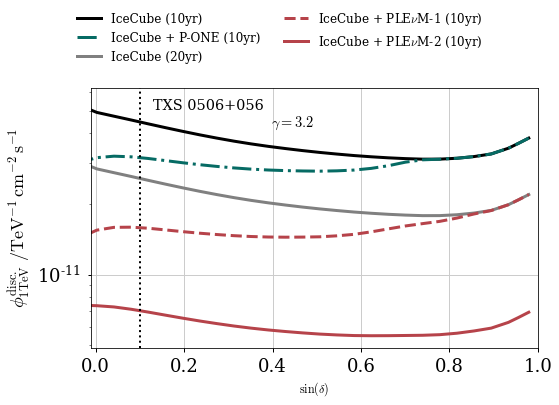

In [36]:
for gamma in gammas:
    f, ax = plt.subplots()
    # conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
    const = 1  #  10**(-2*gamma) / 1.e3
    ax.plot(
        xsd[gamma],
        ic_10yr[gamma] * const,
        color="k",
        ls="-",
        lw=3,
        label=r"IceCube (10yr)",
    )
    ax.plot(
        xsd[gamma],
        ic_ntn[gamma] * const,
        color=colors[2],
        ls="-.",
        lw=3,
        label=r"IceCube + P-ONE (10yr)",
    )
    ax.plot(
        xsd[gamma],
        ic_20yr[gamma] * const,
        color="gray",
        ls="-",
        lw=3,
        label=r"IceCube (20yr)",
    )
    ax.plot(
        xsd[gamma],
        ic_plenum1[gamma] * const,
        color=colors[3],
        ls="--",
        lw=3,
        label=r"IceCube + PLE$\nu$M-1 (10yr)",
    )
    ax.plot(
        xsd[gamma],
        ic_plenum2[gamma] * const,
        color=colors[3],
        lw=3,
        label=r"IceCube + PLE$\nu$M-2 (10yr)",
    )

    ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k")
    ax.axvline(np.sin(sgr_a.icrs.dec), ls="--", color="k")

    ax.set_xlabel(r"$\sin(\delta)$", fontsize="large")
    ax.set_yscale("log")
    ax.set_xlim(-0.01, 1)
    ax.text(
        0.5,
        0.85,
        r"$\gamma={0:.1f}$".format(gamma),
        fontsize="x-large",
        transform=ax.transAxes,
        ha="right",
    )
    ax.set_ylabel(
        r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$",
        # fontsize="large",
    )
    ax.tick_params(axis="both", which="major")
    f.legend(loc="upper center", ncol=2, frameon=False, fontsize="large")
    plt.subplots_adjust(top=0.78)

    ylim = ax.get_ylim()
    ax.text(
        np.sin(txs0506.icrs.dec) + 0.03,
        ylim[1] * 0.9,
        "TXS 0506+056",
        fontsize="x-large",
        va="top",
    )
    f.savefig(
        join(BASEPATH, f"plots/IC+P-ONE_ps_disc_pot_comparison_gamma{int(gamma)}.pdf"),
        bbox_inches="tight",
    )


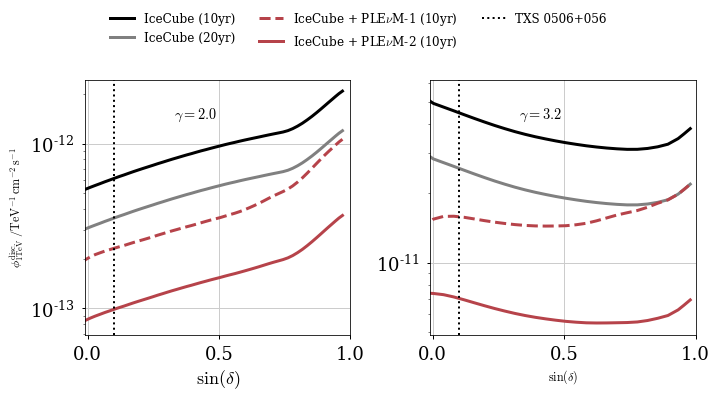

In [40]:
f, axes = plt.subplots(ncols=2, figsize=(10, 5.5))
gamma = 2.0
ax = axes[0]
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1  #  10**(-2*gamma) / 1.e3
ax.plot(
    xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r"IceCube (10yr)"
)
ax.plot(
    xsd[gamma],
    ic_20yr[gamma] * const,
    color="gray",
    ls="-",
    lw=3,
    label=r"IceCube (20yr)",
)
ax.plot(
    xsd[gamma],
    ic_plenum1[gamma] * const,
    color=colors[3],
    ls="--",
    lw=3,
    label=r"IceCube + PLE$\nu$M-1 (10yr)",
)
ax.plot(
    xsd[gamma],
    ic_plenum2[gamma] * const,
    color=colors[3],
    lw=3,
    label=r"IceCube + PLE$\nu$M-2 (10yr)",
)

ax.set_xlabel(r"$\sin(\delta)$")
ax.set_yscale("log")
ax.set_xlim(-0.01, 1)
ax.text(
    0.5,
    0.85,
    r"$\gamma={0:.1f}$".format(gamma),
    fontsize="x-large",
    transform=ax.transAxes,
    ha="right",
)
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$",
    fontsize="large",
)
ax.tick_params(axis="both", which="major")
# add the location of the galactic center and TXS
ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k", label="TXS 0506+056")
f.legend(loc="upper center", ncol=3, frameon=False, fontsize="large")


gamma = 3.2
ax = axes[1]
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1  # 10**(-2*gamma) / 1.e3
ax.plot(
    xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r"IceCube (10yr)"
)
ax.plot(
    xsd[gamma],
    ic_20yr[gamma] * const,
    color="gray",
    ls="-",
    lw=3,
    label=r"IceCube (20yr)",
)
ax.plot(
    xsd[gamma],
    ic_plenum1[gamma] * const,
    color=colors[3],
    ls="--",
    lw=3,
    label=r"IceCube + PLE$\nu$M-1 (10yr)",
)
ax.plot(
    xsd[gamma],
    ic_plenum2[gamma] * const,
    color=colors[3],
    lw=3,
    label=r"IceCube + PLE$\nu$M-2 (10yr)",
)

ax.set_xlabel(r"$\sin(\delta)$", fontsize="large")
ax.set_yscale("log")
ax.set_xlim(-0.01, 1)
ax.text(
    0.5,
    0.85,
    r"$\gamma={0:.1f}$".format(gamma),
    fontsize="x-large",
    transform=ax.transAxes,
    ha="right",
)

ax.tick_params(axis="both", which="major")
# add the location of TXS
ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k", label="TXS 0506+056")

f.tight_layout()
plt.subplots_adjust(top=0.8)
f.savefig(
    join(BASEPATH, f"plots/PLENUM_ps_disc_pot_comparison_gamma20-30_woDots.pdf"), bbox_inches="tight"
)


# Show time evolution

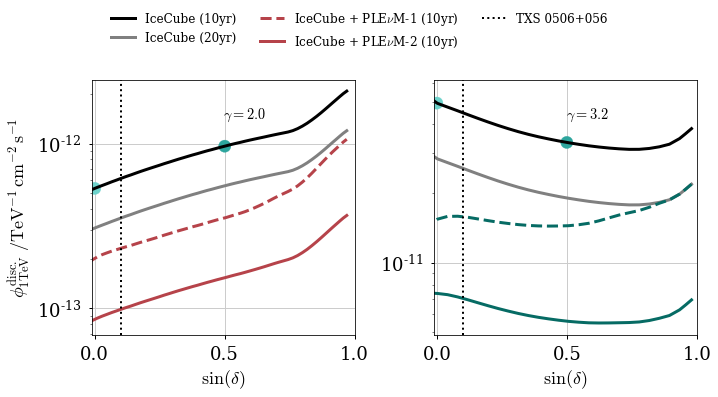

In [45]:
f, axes = plt.subplots(ncols=2, figsize=(10, 5.5))
gamma = 2.0
ax = axes[0]
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1  #  10**(-2*gamma) / 1.e3
ax.plot(
    xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r"IceCube (10yr)"
)
ax.plot(
    xsd[gamma],
    ic_20yr[gamma] * const,
    color="gray",
    ls="-",
    lw=3,
    label=r"IceCube (20yr)",
)
ax.plot(
    xsd[gamma],
    ic_plenum1[gamma] * const,
    color=colors[3],
    ls="--",
    lw=3,
    label=r"IceCube + PLE$\nu$M-1 (10yr)",
)
ax.plot(
    xsd[gamma],
    ic_plenum2[gamma] * const,
    color=colors[3],
    lw=3,
    label=r"IceCube + PLE$\nu$M-2 (10yr)",
)
ax.scatter(
    reference_sdecs,
    splev(reference_sdecs, spl_10yr[gamma]) * const,
    color=colors[:2],
    s=150,
    alpha=1,
)
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_yscale("log")
ax.set_xlim(-0.01, 1)
ax.text(
    0.5,
    0.85,
    r"$\gamma={0:.1f}$".format(gamma),
    fontsize="x-large",
    transform=ax.transAxes,
)
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$",
)
ax.tick_params(axis="both", which="major")
# add the location of the galactic center and TXS
ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k", label="TXS 0506+056")
f.legend(loc="upper center", ncol=3, frameon=False, fontsize="large")


gamma = 3.2
ax = axes[1]
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1  # 10**(-2*gamma) / 1.e3
ax.plot(
    xsd[gamma], ic_10yr[gamma] * const, color="k", ls="-", lw=3, label=r"IceCube (10yr)"
)
ax.plot(
    xsd[gamma],
    ic_20yr[gamma] * const,
    color="gray",
    ls="-",
    lw=3,
    label=r"IceCube (20yr)",
)
ax.plot(
    xsd[gamma],
    ic_plenum1[gamma] * const,
    color=colors[2],
    ls="--",
    lw=3,
    label=r"IceCube + PLE$\nu$M-1 (10yr)",
)
ax.plot(
    xsd[gamma],
    ic_plenum2[gamma] * const,
    color=colors[2],
    lw=3,
    label=r"IceCube + PLE$\nu$M-2 (10yr)",
)
ax.scatter(
    reference_sdecs,
    splev(reference_sdecs, spl_10yr[gamma]) * const,
    color=colors[:2],
    s=150,
    alpha=1,
)
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_yscale("log")
ax.set_xlim(-0.01, 1)
ax.text(
    0.5,
    0.85,
    r"$\gamma={0:.1f}$".format(gamma),
    fontsize="x-large",
    transform=ax.transAxes,
)
ax.tick_params(axis="both", which="major")
# add the location of TXS
ax.axvline(np.sin(txs0506.icrs.dec), ls=":", color="k", label="TXS 0506+056")

f.tight_layout()
plt.subplots_adjust(top=0.8)
f.savefig(
    join(BASEPATH, f"plots/PLENUM_ps_disc_pot_comparison_gamma20-30_Dots.pdf"), bbox_inches="tight"
)


### Make a time evolution plot for the selected declinations

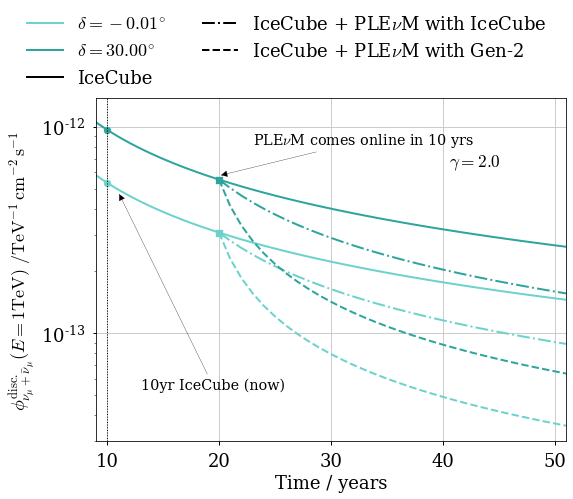

In [54]:
gamma = 2.0
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 1  # 10**(-2*gamma) / 1.e3

t_0 = 10
t_new = np.arange(8, 52)
base_disc_10yr = splev(reference_sdecs, spl_10yr[gamma])

fig, ax = plt.subplots(figsize=(8, 7))
for i, dd in enumerate(reference_ddecs):
    time_evolution_base = base_disc_10yr[i] * (t_0 / t_new) ** 0.8
    p = ax.plot(
        t_new,
        time_evolution_base * const,
        label=rf"$\delta = {dd:1.2f}^{{\circ}}$",
        color=colors[i],
    )
    ax.scatter(t_0, base_disc_10yr[i] * const, color=colors[i])

t_1 = 20
t_new = np.arange(20, 52)  # start Plenum after 20yr IC data (10yrs after "now")
for i, dd in enumerate(reference_ddecs):
    # base values at t_1 = 20yr
    # IC with 20 years
    base_ic = base_disc_10yr[i] * (t_0 / t_1) ** 0.8
    # plenum reference for 10 yrs data taking
    base_plenum = base_disc_10yr[i] * np.exp(
        (
            det_eff[gamma]["IceCube"](reference_sdecs[i])
            - det_eff[gamma]["Plenum-1"](reference_sdecs[i])
        )
        * 0.8
    )

    # plenum with gen2 instead of icecube
    # first, subtract icecube eff from plenum eff
    pl_tmp = np.exp(det_eff[gamma]["Plenum-1"](reference_sdecs[i])) - np.exp(
        det_eff[gamma]["IceCube"](reference_sdecs[i])
    )
    # then, add gen2
    pl_tmp += np.exp(det_eff[gamma]["Gen-2"](reference_sdecs[i]))
    base_plenum_gen2 = base_disc_10yr[i] * np.exp(
        (det_eff[gamma]["IceCube"](reference_sdecs[i]) - np.log(pl_tmp)) * 0.8
    )
    # time evolution
    # plenum starts at t_1=20yrs
    base_plenum_evo = base_plenum * (t_0 / (t_new - t_1)) ** 0.8
    base_plenum_gen2_evo = base_plenum_gen2 * (t_0 / (t_new - t_1)) ** 0.8
    # combine both base vals
    # 20yr IceCube and from then on combined Plenum evolution
    time_evolution = (base_ic ** (-1 / 0.8) + base_plenum_evo ** (-1 / 0.8)) ** -0.8
    time_evolution_gen2 = (
        base_ic ** (-1 / 0.8) + base_plenum_gen2_evo ** (-1 / 0.8)
    ) ** -0.8
    p = ax.plot(t_new, time_evolution * const, color=colors[i], ls="-.")
    p = ax.plot(t_new, time_evolution_gen2 * const, color=colors[i], ls="--")
    ax.scatter(t_new[0], time_evolution[0] * const, color=colors[i], marker="s")

ax.set_yscale("log")
ax.set_xlabel(r"Time / years")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.axvline(10, ls=":", lw=1, color="k")
ax.text(
    0.75,
    0.8,
    r"$\gamma={0:.1f}$".format(gamma),
    fontsize="xx-large",
    transform=ax.transAxes,
)
ax.annotate(
    "10yr IceCube (now)",
    xy=(10.5, base_disc_10yr[0] * const * 0.9),
    xytext=(13, base_disc_10yr[0] * const * 0.1),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="x-large",
)
ax.annotate(
    r"PLE$\nu$M comes online in 10 yrs",
    xy=(20, base_disc_10yr[1] * const * 0.6),
    xytext=(23, base_disc_10yr[1] * const * 0.85),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="x-large",
)
ax.set_xlim(9, 51)
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D(range(1), range(1), color="k", ls="-", label="IceCube"))
handles.append(
    Line2D(
        range(1),
        range(1),
        color="k",
        ls="-.",
        label=r"IceCube + PLE$\nu$M with IceCube",
    )
)
handles.append(
    Line2D(
        range(1), range(1), color="k", ls="--", label=r"IceCube + PLE$\nu$M with Gen-2"
    )
)

fig.legend(handles=handles, loc="upper center", ncol=2, frameon=False)  # mode='expand',
fig.tight_layout()
plt.subplots_adjust(top=0.8)
fig.savefig(
    join(BASEPATH, f"plots/PLENUM_ps_disc_pot_timeevolution_gamma{gamma}.pdf"),
    bbox_inches="tight",
)


## same plot, but gamma=3.2

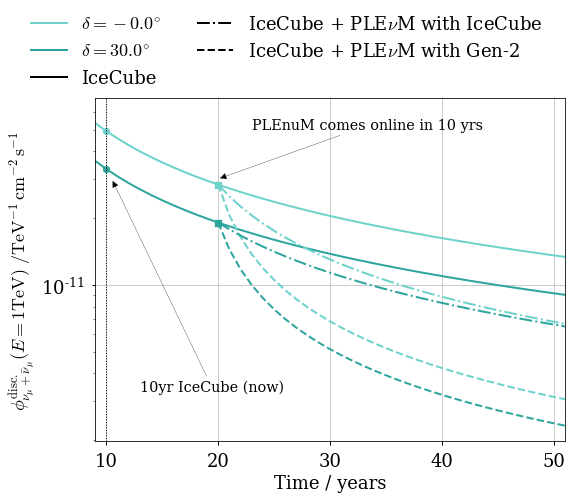

In [57]:
gamma = 3.2
const = 1 

t_0 = 10
t_new = np.arange(8, 52)
base_disc_10yr = splev(reference_sdecs, spl_10yr[gamma])

fig, ax = plt.subplots(figsize=(8, 7))
for i, dd in enumerate(reference_ddecs):
    if dd < -0.1:
        continue
    time_evolution_base = base_disc_10yr[i] * (t_0 / t_new) ** 0.8
    p = ax.plot(
        t_new,
        time_evolution_base * const,
        label=rf"$\delta = {dd:1.1f}^{{\circ}}$",
        color=colors[i],
    )
    ax.scatter(t_0, base_disc_10yr[i] * const, color=colors[i])

t_1 = 20
t_new = np.arange(20, 52)  # start Plenum after 20yr IC data (10yrs after "now")
for i, dd in enumerate(reference_ddecs):  # omit Southern Hemi
    if dd < -0.1:
        continue
    # base values at t_1 = 20yr
    # IC with 20 years
    base_ic = base_disc_10yr[i] * (t_0 / t_1) ** 0.8
    # plenum reference for 10 yrs data taking
    base_plenum = base_disc_10yr[i] * np.exp(
        (
            det_eff[gamma]["IceCube"](reference_sdecs[i])
            - det_eff[gamma]["Plenum-1"](reference_sdecs[i])
        )
        * 0.8
    )

    # plenum with gen2 instead of icecube
    # first, subtract icecube eff from plenum eff
    pl_tmp = np.exp(det_eff[gamma]["Plenum-1"](reference_sdecs[i])) - np.exp(
        det_eff[gamma]["IceCube"](reference_sdecs[i])
    )
    # then, add gen2
    pl_tmp += np.exp(det_eff[gamma]["Gen-2"](reference_sdecs[i]))
    base_plenum_gen2 = base_disc_10yr[i] * np.exp(
        (det_eff[gamma]["IceCube"](reference_sdecs[i]) - np.log(pl_tmp)) * 0.8
    )
    # time evolution
    # plenum starts at t_1=20yrs
    base_plenum_evo = base_plenum * (t_0 / (t_new - t_1)) ** 0.8
    base_plenum_gen2_evo = base_plenum_gen2 * (t_0 / (t_new - t_1)) ** 0.8
    # combine both base vals
    # 20yr IceCube and from then on combined Plenum evolution
    time_evolution = (base_ic ** (-1 / 0.8) + base_plenum_evo ** (-1 / 0.8)) ** -0.8
    time_evolution_gen2 = (
        base_ic ** (-1 / 0.8) + base_plenum_gen2_evo ** (-1 / 0.8)
    ) ** -0.8
    p = ax.plot(t_new, time_evolution * const, color=colors[i], ls="-.")
    p = ax.plot(t_new, time_evolution_gen2 * const, color=colors[i], ls="--")
    ax.scatter(t_new[0], time_evolution[0] * const, color=colors[i], marker="s")

ax.set_yscale("log")
ax.set_xlabel(r"Time / years")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{\nu_\mu + \bar{\nu}_\mu}(E=1\rm TeV) ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.axvline(10, ls=":", lw=1, color="k")
ax.annotate(
    "10yr IceCube (now)",
    xy=(10.5, base_disc_10yr[1] * const * 0.9),
    xytext=(13, base_disc_10yr[1] * const * 0.1),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="x-large",
)
ax.annotate(
    "PLEnuM comes online in 10 yrs",
    xy=(20, 3e-11),
    xytext=(23, 5e-11),
    arrowprops=dict(arrowstyle="-|>", color="k"),
    fontsize="x-large",
)
ax.set_xlim(9, 51)

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D(range(1), range(1), color="k", ls="-", label="IceCube"))
handles.append(
    Line2D(
        range(1),
        range(1),
        color="k",
        ls="-.",
        label=r"IceCube + PLE$\nu$M with IceCube",
    )
)
handles.append(
    Line2D(
        range(1), range(1), color="k", ls="--", label=r"IceCube + PLE$\nu$M with Gen-2"
    )
)

fig.legend(handles=handles, loc="upper center", ncol=2, frameon=False)
fig.tight_layout()
plt.subplots_adjust(top=0.8)
fig.savefig(
    join(BASEPATH, f"plots/PLENUM_ps_disc_pot_timeevolution_gamma{gamma}.pdf"),
    bbox_inches="tight",
)
